<a href="https://colab.research.google.com/github/WittmannF/LRFinder/blob/master/LRFinder_Playground.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Base Code

In [0]:
from keras.callbacks import Callback
import keras.backend as K
import numpy as np
import matplotlib.pyplot as plt

class LRFinder(Callback):
    def __init__(self, min_lr, max_lr):
        self.min_lr = min_lr
        self.max_lr = max_lr
        
    def on_train_begin(self, logs={}):
        n_iterations = self.params['samples']//self.params['batch_size']
        self.learning_rates = np.geomspace(self.min_lr, self.max_lr, \
                                           num=n_iterations+1)
        self.losses=[]
        self.iteration=0
        self.best_loss=0
        
    
    def on_batch_end(self, batch, logs={}):
        loss = logs.get('loss')
        if self.iteration==0 or loss < self.best_loss: 
            self.best_loss = loss
        lr = self.learning_rates[self.iteration]
        K.set_value(self.model.optimizer.lr, lr)
        self.losses.append(loss)
        self.iteration += 1
        if loss > self.best_loss*10: # Stop criteria
            self.model.stop_training = True
    
    def on_train_end(self, logs=None):
        plt.figure(figsize=(12, 6))
        plt.plot(self.learning_rates[:len(self.losses)], self.losses)
        plt.xlabel("Learning Rate")
        plt.ylabel("Loss")
        plt.xscale('log')
        plt.show()
        

4423680/4422102 [==============================] - 1s 0us/step


W0711 18:58:13.420389 140386071209856 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0711 18:58:13.467389 140386071209856 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0711 18:58:13.493056 140386071209856 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0711 18:58:13.518686 140386071209856 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0711 18:58:13.553543 140386071209856 deprecation_wrappe

Epoch 1/1
37120/60000 [=================>............] - ETA: 2s - loss: 0.8512 - acc: 0.7675

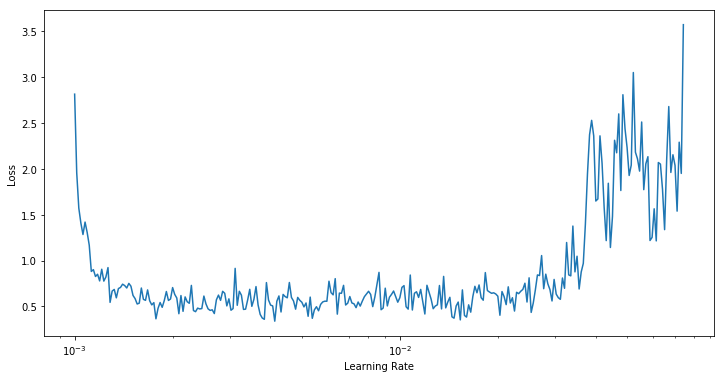

In [0]:
from keras.models import Sequential
from keras.layers import Flatten, Dense
from keras.datasets import fashion_mnist

# 1. Input Data
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

mean, std = X_train.mean(), X_train.std()
X_train, X_test = (X_train-mean)/std, (X_test-mean)/std

# 2. Define and Compile Model
model = Sequential([Flatten(),
                    Dense(512, activation='relu'),
                    Dense(10, activation='softmax')])

model.compile(loss='sparse_categorical_crossentropy', \
              metrics=['accuracy'], optimizer='adam')


# 3. Fit using Callback
lr_finder = LRFinder(min_lr=0.001, max_lr=1)

model.fit(X_train, y_train, batch_size=128, callbacks=[lr_finder])

# Applying Moving Average

In [0]:
from keras.callbacks import Callback
import keras.backend as K
import numpy as np
import matplotlib.pyplot as plt

class LRFinder(Callback):
    def __init__(self, min_lr, max_lr, mom=0.9):
        self.min_lr = min_lr
        self.max_lr = max_lr
        self.mom = mom
        
    def on_train_begin(self, logs={}):
        n_iterations = self.params['samples']//self.params['batch_size']
        self.learning_rates = np.geomspace(self.min_lr, self.max_lr, \
                                           num=n_iterations+1)
        self.losses=[]
        self.iteration=0
        self.best_loss=0
        
    
    def on_batch_end(self, batch, logs={}):
        loss = logs.get('loss')
        
        if self.iteration!=0: # Make loss smoother using momentum
            loss = self.losses[-1]*self.mom+loss*(1-self.mom)

        if self.iteration==0 or loss < self.best_loss: 
            self.best_loss = loss
            
        lr = self.learning_rates[self.iteration]
        K.set_value(self.model.optimizer.lr, lr)
        
        self.losses.append(loss)            
        self.iteration += 1
        if loss > self.best_loss*4: # Stop criteria
            self.model.stop_training = True
    
    def on_train_end(self, logs=None):
        plt.figure(figsize=(12, 6))
        plt.plot(self.learning_rates[:len(self.losses)], self.losses)
        plt.xlabel("Learning Rate")
        plt.ylabel("Loss")
        plt.xscale('log')
        plt.show()

Epoch 1/1
 1792/60000 [..............................] - ETA: 38s - loss: 1.1571 - acc: 0.6088

/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.133202). Check your callbacks.
  % delta_t_median)


34688/60000 [================>.............] - ETA: 3s - loss: 0.7506 - acc: 0.7757

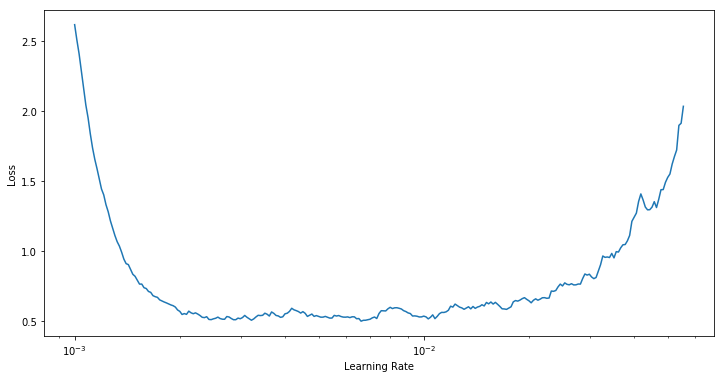

In [0]:
from keras.models import Sequential
from keras.layers import Flatten, Dense
from keras.datasets import fashion_mnist

# 1. Input Data
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

mean, std = X_train.mean(), X_train.std()
X_train, X_test = (X_train-mean)/std, (X_test-mean)/std

# 2. Define and Compile Model
model = Sequential([Flatten(),
                    Dense(512, activation='relu'),
                    Dense(10, activation='softmax')])

model.compile(loss='sparse_categorical_crossentropy', \
              metrics=['accuracy'], optimizer='adam')


# 3. Fit using Callback
lr_finder = LRFinder(min_lr=0.001, max_lr=1, mom=0.9)

model.fit(X_train, y_train, batch_size=128, callbacks=[lr_finder])

In [0]:
from keras.callbacks import Callback
import keras.backend as K
import numpy as np
import matplotlib.pyplot as plt

class LRFinder(Callback):
    def __init__(self, min_lr, max_lr, mom=0.9):
        self.min_lr = min_lr
        self.max_lr = max_lr
        self.mom = mom
        
    def on_train_begin(self, logs={}):
        n_iterations = self.params['samples']//self.params['batch_size']
        self.learning_rates = np.geomspace(self.min_lr, self.max_lr, \
                                           num=n_iterations+1)
        self.losses=[]
        self.iteration=0
        self.best_loss=0
        
    
    def on_batch_end(self, batch, logs={}):
        loss = logs.get('loss')
        
        if self.iteration!=0:
            loss = self.losses[-1]*self.mom+loss*(1-self.mom)

        if self.iteration==0 or loss < self.best_loss: 
            self.best_loss = loss
            
        lr = self.learning_rates[self.iteration]
        K.set_value(self.model.optimizer.lr, lr)
        
        self.losses.append(loss)            
        self.iteration += 1
        if loss > self.best_loss*4: # Stop criteria
            self.model.stop_training = True
    
    def on_train_end(self, logs=None):
        plt.figure(figsize=(12, 6))
        plt.plot(self.learning_rates[:len(self.losses)], self.losses)
        plt.xlabel("Learning Rate")
        plt.ylabel("Loss")
        plt.xscale('log')
        plt.show()
        